In [3]:
import pandas as pd
import json
import spacy

In [4]:
#Spacy
nlp = spacy.load('de_core_news_sm')

#Read and format dataset
with open('tech_soft_none.json', 'r',encoding = 'utf8') as f:
    data = json.load(f)       
        
df = pd.DataFrame.from_dict(data["data"])
df.head(10)

,label,text
0,none,"Standort Trovarit AG München, Deutschland"
1,none,Wir freuen uns auf Ihre Bewerbung unter Angabe...
2,tech,Qualifikation zur Heimleitung gemäß Heimperson...
3,soft,Gute organisatorische und konzeptionelle Fähig...
4,soft,"Teamfähigkeit, hohe Flexibilität und Einsatzbe..."
5,soft,Überdurchschnittliche Einsatzbereitschaft
6,none,HomeIhre Karriere bei LeasePlanStellenangebote...
7,tech,Steuerkenntnisse sind sehr wünschenswert
8,soft,Kreativität und schnelle Auffassungsgabe
9,none,budget/forecast/prior year/prior month) and pr...


In [5]:
from collections import Counter

#Get most common words for bag of words
alltext = ""
for d in df["text"]:
    alltext += d
doc = nlp(alltext)
words = [token.text for token in doc if token.is_stop != True and token.is_punct != True 
         and token.like_num != True and token.pos_ != "SYM" and token.shape_[0:3].lower() == 'xxx']

word_freq = Counter(words)
common_words = word_freq.most_common(5000)
word_features = [t[0] for t in common_words]

In [6]:
#define feature vectors
def find_features(doc):
    words = doc
    features = []
    for w in word_features:
        features.append(1 if (w in words) else 0)
    return features

In [7]:
import numpy as np

#Extract feature vectors for each text entry with its corresponding label
featuresets = np.array([(find_features(df["text"][index]), df["label"][index]) for index,_ in df.iterrows()])

In [8]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

#Prepare data for training
X = np.array([x[0] for x in featuresets[:]])
Y = [x[1] for x in featuresets[:]]

#Label Encoding
le = LabelEncoder().fit(Y)
Y = np.array(le.transform(Y))
    
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.25)



In [9]:
#Prediction with Multinomial Naive Bayes 
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

clf = MultinomialNB()
clf.fit(trainX, trainY)
accuaracy = clf.score(testX,testY)
print("Accuarcy: {0:.3%}".format(accuaracy))

Accuarcy: 92.353%


Confusion matrix, without normalization
[[992  52  39]
 [ 15 835  25]
 [ 19  46 540]]
Normalized confusion matrix
[[0.91597415 0.04801477 0.03601108]
 [0.01714286 0.95428571 0.02857143]
 [0.03140496 0.07603306 0.89256198]]


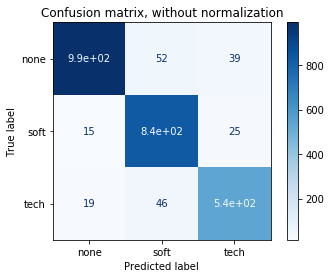

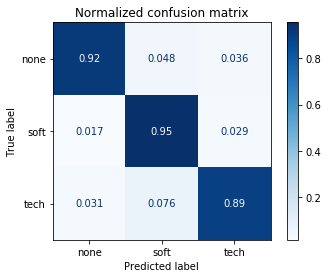

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf, testX, testY,
                                 display_labels=["none","soft","tech"],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)
    
plt.show()

Despite different train/test spliting ratios and word features selected, couldn't improve more than 95%


New model to train: Logistic Regression

In [13]:
from sklearn.linear_model import LogisticRegression

#LogisticRegression model and training
clflr = LogisticRegression(solver = 'newton-cg', multi_class = 'multinomial')
clflr.fit(trainX, trainY)
accuaracy = clflr.score(testX,testY)

print("Accuarcy: {0:.3%}".format(accuaracy))

Accuarcy: 93.328%


Bow let's try with a Neural Network (1-hidden-layer)

In [14]:
#Prepare data for training
X = np.array([x[0] for x in featuresets[:]])
Y = [x[1] for x in featuresets[:]]

#One-hot-encoding
enc = OneHotEncoder(sparse = False)
Y = enc.fit_transform(np.array(Y).reshape(-1,1))
    
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.25)

NameError: name 'OneHotEncoder' is not defined

In [ ]:
from keras.models import Sequential
from keras import layers

input_dim = trainX.shape[1]  # Number of features

model = Sequential()
model.add(layers.Dense(120, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary()

In [ ]:
hist = model.fit(trainX, trainY,
                    verbose = 1,
                    epochs=15,
                    validation_data = (testX,testY),
                    batch_size=500)

In [ ]:
#history_dict = history.history
#history_dict.keys()

plt.subplot(2,1,1)
# Plot training & validation accuracy values
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.subplot(2,1,2)
# Plot training & validation loss values
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
#Just to check i'll use some personal Anschreiben texts 
#It's extra just for "fun"

rawData = "Für mich bedeutet die Zusammenarbeit mit Ihnen eine berufliche Koalition aneignen, wo ich mir eine so bekannte Arbeitskultur Ihres Unternehmen, und mit meiner gesammelten Erfahrung arbeiten kann"
newData = np.asarray(find_features(rawData))

newData = newData.reshape(1,-1)

predLabel = np.zeros(3)
predIndex = np.argmax(model.predict([newData]))
predLabel[predIndex] = 1

predLabel = predLabel.reshape(1,-1)

predLabelStr = enc.inverse_transform(predLabel)[0][0]

print(rawData + " =======> " + predLabelStr)
